In [1]:
!pip install gym[classic_control]
!pip install tqdm
!pip install gym[box2d]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt 
import random
import math
# import progressbar
import time

/home/rahul/.local/lib/python3.6/site-packages/gym/core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [3]:
env_name = "Acrobot-v1"
render_Mode = "human"
# env = gym.make(env_name)

In [4]:
def getAngle(cos_val, sin_val):
    a_acos = math.acos(cos_val)
    angle = 0
    if sin_val < 0:
        angle = math.degrees(-a_acos) % 360
    else: 
        angle = math.degrees(a_acos)
    return angle

In [5]:
def transformObs(obs):
    ang1 = int(getAngle(obs[0], obs[1])/20)
    ang2 = int(getAngle(obs[2], obs[3])/20)
    new_obs = []
    new_obs.append(ang1)
    new_obs.append(ang2)
    new_obs.append(int((obs[4] + 12.57)/3))
    new_obs.append(int((obs[5] + 28.28)/3))
    return new_obs

In [6]:
pi = [[[[0 for _ in range(19)] for _ in range(9)] for _ in range(18)] for _ in range(18)]

In [7]:
val_func = [[[[0 for _ in range(19)] for _ in range(9)] for _ in range(18)] for _ in range(18)]

In [8]:
q = [[[[[0 for _ in range(3)] for _ in range(19)] for _ in range(9)] for _ in range(18)] for _ in range(18)]

In [9]:
# vis = [[[[0 for _ in range(7)] for _ in range(6)] for _ in range(6)] for _ in range(6)]

In [10]:
next_state = [[[[[(-1, -1, -1, -1) for _ in range(3)] for _ in range(19)] for _ in range(9)] for _ in range(18)] for _ in range(18)]

In [11]:
gamma = 0.8

In [12]:
def performEpisode():
    Acrobot = gym.make(env_name)
#     Acrobot = gym.make(env_name, render_mode=render_Mode)
    pre_obs = Acrobot.reset()
    
    pre_obs = transformObs(pre_obs)
    done = False
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        val = random.uniform(0,1)
        act = 0
        if val <= 0.1:
            act = random.randint(0, 2) 
        else:   
            act = pi[a][b][c][d]
        obs, reward, done, info = Acrobot.step(act)
        obs = transformObs(obs)
        a_n, b_n, c_n, d_n = int(obs[0]), int(obs[1]), int(obs[2]), int(obs[3])
        next_state[a][b][c][d][act] = (a_n, b_n, c_n, d_n)
        q[a][b][c][d][act] = reward + gamma*val_func[a_n][b_n][c_n][d_n]  
        pre_obs = obs         
    Acrobot.close()

In [13]:
def getReward():
    Acrobot = gym.make(env_name)
    pre_obs = Acrobot.reset() 
    pre_obs = transformObs(pre_obs)
    done = False
    tot_reward = 0
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        req_act = random.randint(0, 2)   
        max_val = -200000000000
        for act in range(0, 3):
            a_n, b_n, c_n, d_n = next_state[a][b][c][d][act]
            if a_n!=-1 and b_n!=-1 and c_n!=-1 and d_n!=-1:
                if val_func[a_n][b_n][c_n][d_n] >= max_val:
                    max_val = val_func[a_n][b_n][c_n][d_n]
                    req_act = act 
 
        pre_obs, reward, done, info = Acrobot.step(req_act)
        tot_reward += reward
        pre_obs = transformObs(pre_obs)   
    Acrobot.close() 
    return tot_reward

In [14]:
def policy_eval():
    performEpisode()
    for i in range(18):
        for j in range(18):
            for v1 in range(9):
                for v2 in range(19):
                    val_func[i][j][v1][v2] = 0
                    for act in range(3):
                        val_func[i][j][v1][v2] += 0.3333*q[i][j][v1][v2][act]                  

In [15]:
def policy_improv():
    for i in range(18):
        for j in range(18):
            for v1 in range(9):
                for v2 in range(19):
                    max_val = -200000000000
                    for act in range(0, 3):
                        a, b, c, d = next_state[i][j][v1][v2][act]
                        if a!=-1 and b!=-1 and c!=-1 and d!=-1 and val_func[a][b][c][d] >= max_val:
                            max_val = val_func[a][b][c][d]
                            pi[i][j][v1][v2] = act    

In [16]:
x_rew = []
avg_reww = []
orig_reww = []
success_rate = []
for cnt in tqdm (range (80000), desc="Loading…", ascii=False, ncols=100):
    policy_eval()
    policy_improv()
    if cnt>0 and cnt%800 == 0:
        rew = 0
        orig_reww.append(getReward())
        success_count = 0
        for _ in range(250):
            x = getReward()
            rew += x
            if x > -500:
                success_count += 1
        avg_reww.append(rew/250) 
        success_rate.append(success_count/250)
        x_rew.append(cnt/800)

Loading…:   0%|                                                           | 0/80000 [00:00<?, ?it/s]/home/rahul/.local/lib/python3.6/site-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/rahul/.local/lib/python3.6/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=

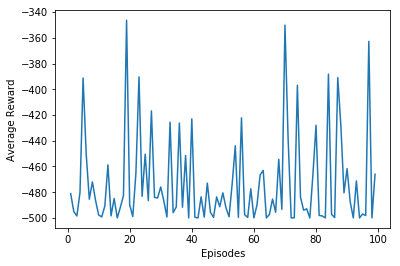

In [17]:
plt.plot(x_rew, avg_reww)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.show()

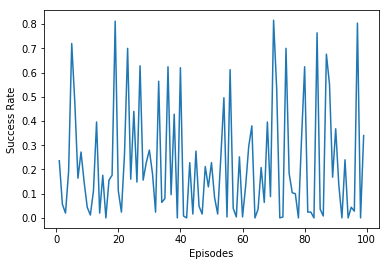

In [18]:
plt.plot(x_rew, success_rate)
plt.xlabel("Episodes")
plt.ylabel("Success Rate")
plt.show()

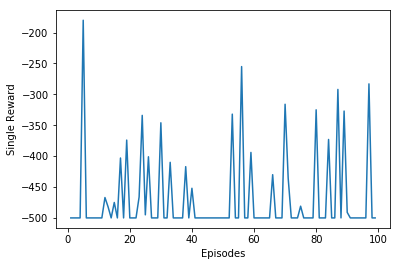

In [19]:
plt.plot(x_rew, orig_reww)
plt.xlabel("Episodes")
plt.ylabel("Single Reward")
plt.show()

In [20]:
Acrobot = gym.make(env_name)
# Acrobot = gym.make(env_name, render_mode=render_Mode)
pre_obs = Acrobot.reset() 
pre_obs = transformObs(pre_obs)
done = False
reward = 0
while not done:
    a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
    act = pi[a][b][c][d]
    pre_obs, rew, done, info = Acrobot.step(act)
    pre_obs = transformObs(pre_obs)
    reward += rew
Acrobot.close()    
print(reward)    

-500.0


In [21]:
reward = 0
min_iter = 500
rew_list = []
success = 0
for _ in tqdm (range (1000), desc="Loading…", ascii=False, ncols=100):
    Acrobot = gym.make(env_name)
    pre_obs = Acrobot.reset() 
    pre_obs = transformObs(pre_obs)
    done = False
    cur = 0
    while not done:
        a, b, c, d = int(pre_obs[0]), int(pre_obs[1]), int(pre_obs[2]), int(pre_obs[3])
        act = pi[a][b][c][d]
        pre_obs, rew, done, info = Acrobot.step(act)
        pre_obs = transformObs(pre_obs)
        cur += rew
    reward += cur 
    if cur > -500:
        success += 1
    min_iter = min(min_iter, -cur)
    rew_list.append(cur)
    Acrobot.close()
rew_list.sort(reverse=True)   
print("Average reward:", reward/1000) 
print("Highest Reward:", -min_iter)
print("Success Rate", success/1000)
print(rew_list[:50])

Loading…: 100%|█████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 14.01it/s]

Average reward: -458.939
Highest Reward: -188.0
Success Rate 0.38
[-188.0, -193.0, -198.0, -218.0, -221.0, -238.0, -243.0, -244.0, -246.0, -247.0, -247.0, -248.0, -249.0, -251.0, -254.0, -255.0, -260.0, -262.0, -263.0, -263.0, -268.0, -268.0, -269.0, -270.0, -272.0, -277.0, -277.0, -278.0, -279.0, -280.0, -281.0, -284.0, -285.0, -285.0, -286.0, -286.0, -286.0, -286.0, -287.0, -287.0, -289.0, -289.0, -290.0, -290.0, -290.0, -292.0, -293.0, -294.0, -296.0, -298.0]
